In diesem Notebook wird exemplarisch die Berechnung der Transinformationen in einem Neuronalen Netz berechnet, wie sie von Shwartz-Ziv und Tishby genutzt wird. Um die Berechnung auch Schritt für Schritt manuell nachrechenbar zu gestalten, kommt ein sehr minimales Netz mit sehr minimalen Testdaten zum Einsatz. 

# Beispiel Modell

Das Modell in diesem Beispiel besteht aus einer Input-Schicht, einem hidden-Layer mit jeweils 3 Neuronen und einer Output-Schicht. 

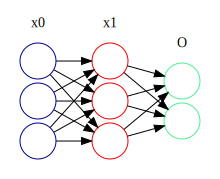

In [1]:
import os
from graphviz import Source

dot = Source(open('graph.dot', 'r').read())
dot

## Parameter

In [2]:
import pandas as pd
from IPython.display import display
import numpy as np

weights = [np.array([[0.3,0.2,-0.4], [-0.9, 0.01, 0.5], [0.1, -0.4, -0.5]]),
           np.array([0.3, 0.1, 0.6]),
           np.array([[0.5, -0.1], [-0.5, -0.1], [0.2, 0.6]]),
           np.array([0.7, 0.2])]

x = np.array([[1,1,0],[1,0,1],[0,1,0],[0,1,1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])


display(pd.DataFrame(weights[0], columns=["x11", "x12", "xO"]))
display(pd.DataFrame(weights[1], columns=["bx1"]))
display(pd.DataFrame(weights[2], columns=["O2", "O1"]))
display(pd.DataFrame(weights[3], columns=["bO"]))

,x11,x12,xO
0,0.3,0.20,-0.4
1,-0.9,0.01,0.5
2,0.1,-0.40,-0.5


,bx1
0,0.3
1,0.1
2,0.6


,O2,O1
0,0.5,-0.1
1,-0.5,-0.1
2,0.2,0.6


,bO
0,0.7
1,0.2


## Modell erstellen

In [3]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K


model = Sequential()
model.add(Dense(3, activation='tanh', input_shape=(3,)))
model.add(Dense(2, activation='sigmoid'))

model.set_weights(weights)

Using TensorFlow backend.
W1006 08:08:22.093968 139748904544064 deprecation.py:506] From /home/robin/wvin/.venv/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Berechnung der einzelnen Aktivierungswerte

In [4]:
input_placeholder = model.input
output_placeholder = [layer.output for layer in model.layers]
activation_functions = [K.function([input_placeholder], [out]) for out in output_placeholder]

activations = [func([x]) for func in activation_functions]

activations

W1006 08:08:24.771457 139748904544064 module_wrapper.py:139] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



[[array([[-0.29131255,  0.3004371 ,  0.6043678 ],
         [ 0.6043678 , -0.099668  , -0.29131255],
         [-0.53704953,  0.10955847,  0.800499  ],
         [-0.4621171 , -0.28213483,  0.53704953]], dtype=float32)],
 [array([[0.62831587, 0.6368477 ],
         [0.729829  , 0.49368596],
         [0.63106674, 0.673278  ],
         [0.6720383 , 0.6448906 ]], dtype=float32)]]

## Output

In [5]:
model.predict(np.array(x))

array([[0.62831587, 0.6368477 ],
       [0.729829  , 0.49368596],
       [0.63106674, 0.673278  ],
       [0.6720383 , 0.6448906 ]], dtype=float32)

# Detaillierte Berechunung 

Wir haben nun alle notwendigen Daten um die Transinformation zu berechnen. 
Die folgende Berechnung ist nicht auf Effizienz und Schnelligkeit ausgelegt sondern soll in erster Linie die Berechnung verdeutlichen und nachvollziehbar machen.

## Berechnung der Wahrscheinlichkeiten von Input und Output 

Im ersten Schritt berechnen wir $P(X), P(Y),P(Y|X)$.

Um $P(X)$ zu berechnen, müssen identische Werte in X zusammengefasst werden. Anschließend wird die Häufigkeit der vereinzelten Werte durch die Summe geteilt. 

In [6]:
x_unique_array, x_unique_indices, x_unique_inverse, x_unique_counts = np.unique(x, True, True, True, axis=0)
pxs = x_unique_counts / float(np.sum(x_unique_counts))
display(pxs)

array([0.25, 0.25, 0.25, 0.25])

In diesem Fall beinhaltet $X$ nur 4 Werte und es tritt kein Wert doppelt auf, daher ist jeder Wert gleich wahrscheinlich. Für jeden der 4 Werte entspricht die Wahrscheinlichkeit damit $0.25$

$P(Y|X)$ gibt die Wahrscheinlichkeit an, mit der ein bestimmter Y-Wert gezogen wird, wenn X bekannt ist.

In [7]:
pys = np.sum(y, axis=0) / float(y.shape[0])

p_y_given_x = []
for i in range(0, len(x_unique_array)):
    indexs = x_unique_inverse == i
    p_y_x_current = np.mean(y[indexs, :], axis=0)
    p_y_given_x.append(p_y_x_current)
    
p_y_given_x = np.array(p_y_given_x).T

y_unique_array, y_unique_indices, y_unique_inverse, y_unique_counts = np.unique(y, return_index=True, return_inverse=True, return_counts=True, axis=0)


## Binning der activation values

Um die Wahrscheinlichkeiten und damit die Entropie der einzelnen Layer $T$ berechnen zu können, müssen sie in Intervalle (Bins) eingeteilt werden. Dabei werden ähnliche Werte die in einem definierten Intervall liegen zu dem gleichen Wert zusammengefasst. Mit der endlichen Menge an Testdaten kann sonst keine Aussage über die Wahrscheinlichkeit eines bestimmten Wertes getroffen werden. 
In diesem Beispiel werden 10 Bins verwendet. 
Schwartz-Ziv verwendet in seiner Implementierung 30 Bins.

In [8]:
num_of_bins = 10
bins = np.linspace(-1, 1, num_of_bins)
display(str(bins))

'[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111\n  0.33333333  0.55555556  0.77777778  1.        ]'

In [9]:
t1_data = np.squeeze(np.array(activations[0]))
display(t1_data)

array([[-0.29131255,  0.3004371 ,  0.6043678 ],
       [ 0.6043678 , -0.099668  , -0.29131255],
       [-0.53704953,  0.10955847,  0.800499  ],
       [-0.4621171 , -0.28213483,  0.53704953]], dtype=float32)

In [10]:
t1_data_binned = bins[np.digitize(np.squeeze(t1_data.reshape(1, -1)), bins) -1].reshape(len(t1_data), -1)
display(t1_data_binned)

array([[-0.33333333,  0.11111111,  0.55555556],
       [ 0.55555556, -0.11111111, -0.33333333],
       [-0.55555556, -0.11111111,  0.77777778],
       [-0.55555556, -0.33333333,  0.33333333]])

`t1_data_binned ` beinhaltet jetzt die activation values des ersten Layers in die Töpfe aus `bins` einsortiert. 

Das gleiche wird selbstverständlich auch mit den activation values des Layers $T_2$ gemacht.

In [11]:
t2_data = np.squeeze(np.array(activations[1]))
display(t2_data)

array([[0.62831587, 0.6368477 ],
       [0.729829  , 0.49368596],
       [0.63106674, 0.673278  ],
       [0.6720383 , 0.6448906 ]], dtype=float32)

In [12]:
t2_data_binned = bins[np.digitize(np.squeeze(t2_data.reshape(1, -1)), bins) -1].reshape(len(t2_data), -1)
display(t2_data_binned)

array([[0.55555556, 0.55555556],
       [0.55555556, 0.33333333],
       [0.55555556, 0.55555556],
       [0.55555556, 0.55555556]])

## Informationsberechnung

Die Transinformation wird nach der Formel $I(X|T)=H(T) - H(T|X)$ berechnet. Demnach werden die Entropie von $T$ und die bedingte Entropie von $T$ gegeben $X$ bzw. $Y$ zur Berechnung benötigt.
Da für die Transinformation $I(X;Y) = I(Y;X)$ gilt, ist die genaue "Reihenfolge" der Parameter nicht relevant.

Zur Berechnung der Entropie $H(T)$ wird wieder die Häufigkeit des Vorkommens der einzelnen Werte benötigt. Dies ist der dritte Rückgabeparameter der Funktion `unique`

In [13]:
_, t1_binned_unique_counts = np.unique(t1_data_binned, return_index=False, return_inverse=False, return_counts=True, axis=0)

# Wahrscheinlichkeit einen der (gebinnten) Werte des Layers T zu ziehen.
p_t1 = t1_binned_unique_counts / float(sum(t1_binned_unique_counts))
# Entropie des layers T
H_t1 = -np.sum(p_t1 * np.log2(p_t1))
H_t1

2.0

In [14]:
_, t2_binned_unique_counts = np.unique(t2_data_binned, return_index=False, return_inverse=False, return_counts=True, axis=0)

p_t2 = t2_binned_unique_counts / float(sum(t2_binned_unique_counts))
H_t2 = -np.sum(p_t2 * np.log2(p_t2))
H_t2

0.8112781244591328

Die Funktion `calc_conditional_entropy_for_given_y` berechnet die bedingte Entropie für ein gebenes $i$, also $P(X=x)H(T|X=x)$

In [15]:
def calc_conditional_entropy_for_given_y(t_data_for_i, px_for_i):
    unique_array, unique_counts = np.unique(t_data_for_i, return_counts=True, axis=0)
    
    p_current_t = unique_counts / float(sum(unique_counts))
        
    H = px_for_i * (-np.sum(p_current_t * np.log2(p_current_t)))
    
    return H

In den folgenden zwei Zeilen wird die bedingte Entropie für $T$ gegeben $X$ bzw. $Y$ berechnet.
$$H(T|X) = \sum_{x\in L:P(X=x)>0}{P(X=x) H(T|X=x)}$$

In [16]:
H_T1_given_X_array = [calc_conditional_entropy_for_given_y(t1_data_binned[x_unique_inverse == i,:], pxs[i]) for i in range(pxs.shape[0])]
H_T1_given_X = np.sum(H_T1_given_X_array)

H_T1_given_Y_array = [calc_conditional_entropy_for_given_y(t1_data_binned[y_unique_inverse == i,:], pys[i]) for i in range(pys.T.shape[0])]
H_T1_given_Y = np.sum(H_T1_given_Y_array)

In [17]:
H_T2_given_X_array = [calc_conditional_entropy_for_given_y(t2_data_binned[x_unique_inverse == i,:], pxs[i]) for i in range(pxs.shape[0])]
H_T2_given_X = np.sum(H_T2_given_X_array)

H_T2_given_Y_array = [calc_conditional_entropy_for_given_y(t2_data_binned[y_unique_inverse == i,:], pys[i]) for i in range(pys.T.shape[0])]
H_T2_given_Y = np.sum(H_T2_given_Y_array)

Schlussendlich wird die Transinformation des Layers $T_1$ berechnet.
$$I(X;T)=H(T) - H(T|X)$$

In [18]:
I_X_T1 = H_t1 - H_T1_given_X
I_Y_T1 = H_t1 - H_T1_given_Y

In [19]:
I_X_T2 = H_t2 - H_T2_given_X
I_Y_T2 = H_t2 - H_T2_given_Y

## Ergebnis

Damit ist das Ergebnis der Berechnung vollständig.

In [20]:
print("Layer 1:")
print('I(X; T1): ' + str(I_X_T1) + ' I(Y; T1): ' + str(I_Y_T1))

print("Layer 2:")
print('I(X; T2): ' + str(I_X_T2) + ' I(Y; T2): ' + str(I_Y_T2))

Layer 1:
I(X; T1): 2.0 I(Y; T1): 1.0
Layer 2:
I(X; T2): 0.8112781244591328 I(Y; T2): 0.31127812445913283
